In [1]:
import galsim
import seaborn as sns

from utils import *
from model import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [26]:
n_star = 100
wid_strip, n_strip = 12, 14
mu = 884
sigma = 1e-1

In [21]:
# Image Parameter
image_size = 401
pixel_scale = 2.5                                # arcsec/pixel

# PSF Parameters
beta_psf = 10                                    # moffat beta, in arcsec
fwhm = 2.28 * 2.5
gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pixel_scale                  # moffat core width, in pix

n0 = 3.3                                         # true power index
n_s = np.array([n0, 2.8, 1.5, 4])
frac = 0.1                                       # fraction of power law component
theta_0 = 5.                                     # radius at which power law is flattened, in arcsec
theta_s = np.array([theta_0, 60, 150, 900])      # transition radius in arcsec

In [32]:
params_pow = {"gamma":gamma, "beta":beta_psf, "frac":frac, "n":n0, 'theta_0':theta_0}
psf = PSF_Model(params=params_pow, aureole_model='power')

In [38]:
params_mpow = {"gamma":gamma, "beta":beta_psf, "frac":frac, "n_s":n_s, 'theta_s':theta_s}
psf = PSF_Model(params=params_mpow, aureole_model='multi-power')

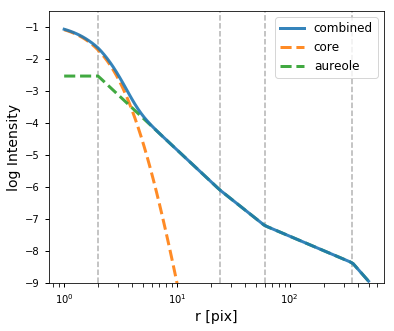

In [5]:
# Plot analytical 1D profile
psf.plot(size=500)

# of medium bright (flux:1.1e+05~1.2e+07) stars: 11 
# of very bright (flux>1.2e+07) stars : 2
Not many bright stars, truth and mock will be generated in serial.


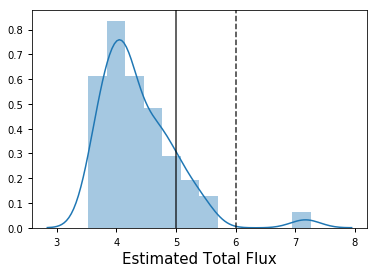

In [39]:
# Star Distribution
############################################

# Generate randomn star positions
np.random.seed(626)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[(SE_cat_full.FLAGS<8)]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(888)
Flux = Flux_Auto_SE.sample(n=n_star).values

# Augment Flux
Flux = Flux * 10
Flux[Flux>1e6] = Flux[Flux>1e6] * 10

# Convert Flux to Astropy Moffat Amplitude
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 1e5
F_verybright = 1e6

bright = Flux > F_bright
verybright = Flux > F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])

print("# of medium bright (flux:%.2g~%.2g) stars: %d "\
      %(Flux[bright].min(), Flux[verybright].min(), num_medbright))

print("# of very bright (flux>%.2g) stars : %d"\
      %(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")
    parallel = True

sns.distplot(np.log10(Flux),label="log Flux (tot)")
plt.axvline(np.log10(F_bright), color="k", ls="-",alpha=0.8)
plt.axvline(np.log10(F_verybright), color="k", ls="--",alpha=0.8)
plt.xlabel('Estimated Total Flux', fontsize=15)
plt.show()

In [40]:
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e6, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e

In [ ]:
# Galsim 2D model averaged in 1D
contrast = Amps.max() / sigma * 3
psf.plot_model_galsim(psf_c, psf_e, image_size, contrast=contrast)

Generate noise background w/ stddev = 0.1.
Generate base image of faint stars (flux < 1e+06).
Generate the truth image (faint stars with Moffat only).
Rendering bright stars in serial...
Total Time: 1.361s


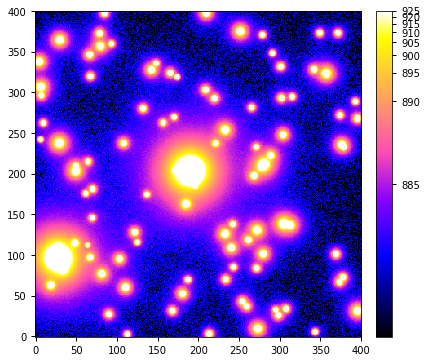

In [36]:
print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, sigma)

print("Generate base image of faint stars (flux < %.2g)."%(F_verybright))
image_base = make_base_image(image_size, star_pos=star_pos[~bright], Flux=Flux[~bright], psf_base=star_psf)

print("Generate the truth image (faint stars with Moffat only).")
image = make_truth_image(psf, star_pos, Flux, image_size)
image = image + image_base + mu + noise_image

plt.figure(figsize=(7,6))
im = plt.imshow(image, vmin=mu, vmax=925, norm=norm1, origin="lower", cmap="gnuplot2")
colorbar(im)

Mask inner regions of stars in dual mode:  S/N > 3 / r < 60 (24) pix 
Use sky strips crossing very bright stars


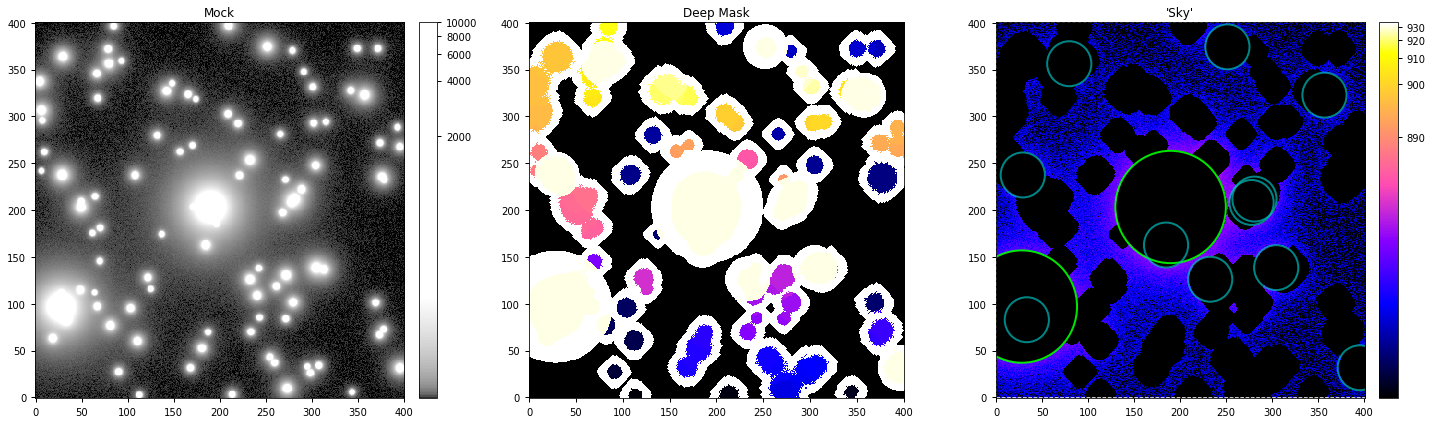

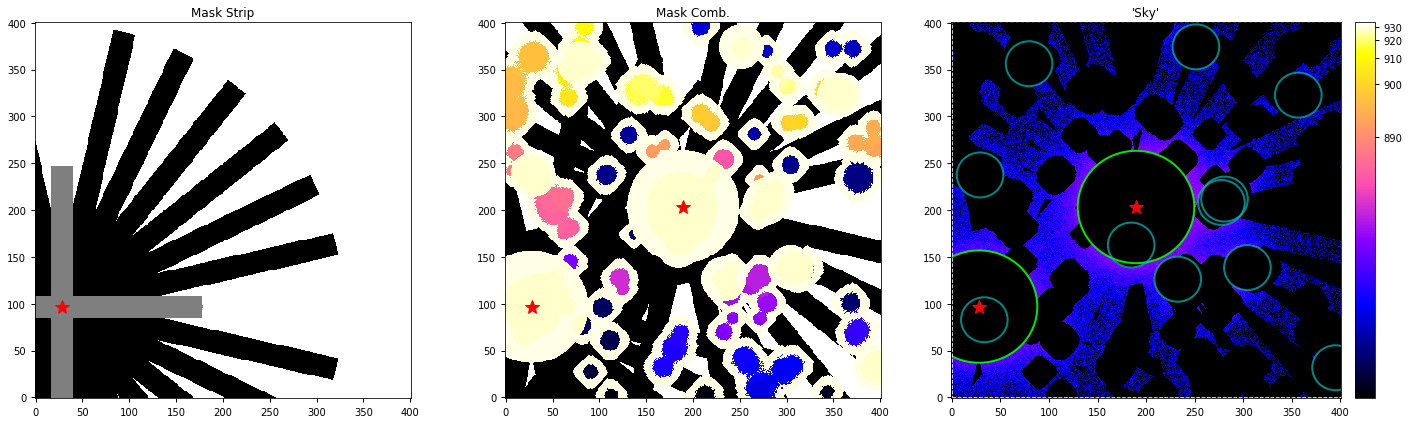

In [37]:
# Masking
r_core_s = np.array([24 if F < F_verybright else 60 for F in Flux[bright]])

r_core_A, r_core_B = np.unique(r_core_s)[::-1]
print("Mask inner regions of stars in dual mode:  S/N > 3 / r < %d (%d) pix "%(r_core_A, r_core_B))
mask_deep, seg_map, _ = make_mask_map_dual(image, star_pos=star_pos[bright],
                                                 r_core=r_core_s, nlevels=128, contrast=0.001,
                                                 sn_thre=3, b_size=25, npix=4, n_dilation=10)

draw_mask_map(image, seg_map, mask_deep, star_pos[verybright], star_pos[medbright],
              r_core=[r_core_A, r_core_B], vmin=mu, vmax=mu+50)

print("Use sky strips crossing very bright stars")
mask_strip_s, mask_cross_s = make_mask_strip(image_size, star_pos[verybright], Flux[verybright], 
                               width=wid_strip, n_strip=n_strip, dist_strip=300)

mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
seg_comb = seg_map.copy()
seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
mask_comb = (seg_comb!=0)

j = Flux[verybright].argsort()
ma_strip, ma_cross = mask_strip_s[j][-1], mask_cross_s[j][-1]
draw_mask_map_strip(image, seg_comb, mask_comb, ma_strip, ma_cross,
                    star_pos[verybright], star_pos[medbright],
                    r_core=[r_core_A, r_core_B], vmin=mu, vmax=mu+50)